In [1]:
#This notebook provides twitter sentiment analysis for Video WebConferencing Products: Zoom, Cisco Webex,
#Microsoft Teams, Skype.

# Import some libraries
from twitterscraper import query_tweets
import pandas as pd
import datetime
import time
import datetime as datetime
import re
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# 1. Pull in tweets from CSV Files of previous scrapping runs from dates January 1st to April 12th 2020
webex_df = pd.read_csv("webex_df.csv")
skype_df = pd.read_csv("skype_df.csv")
teams_df = pd.read_csv("teams_df.csv")

INFO: {'User-Agent': 'Mozilla/5.0 (Windows; U; Windows NT 6.1; rv:2.2) Gecko/20110201'}
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/glynnhofbauer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#adding Product column to keep track of which tweet came from which dataframe 
webex_df['product'] = 'webex'
skype_df['product'] = 'skype'
teams_df['product'] = 'teams'

In [3]:
tweets_df = pd.DataFrame(columns = ['timestamp', 'username',  'screen_name', 'user_id','tweet_id', 
                                    'text', 'likes', 'replies', 'retweets','tweet_url', 'parent_tweet_id'])

# Now append the second dataframe to the first one
tweets_df=tweets_df.append(webex_df, ignore_index = True)
tweets_df=tweets_df.append(skype_df, ignore_index = True)
tweets_df=tweets_df.append(teams_df, ignore_index = True)
tweets_df.shape

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


(30147, 13)

In [4]:
tweets_df['text']=tweets_df['text'].apply(str)

In [5]:
import numpy as np
tweets_df['raw'] = np.nan
for index, row in tweets_df.iterrows():
     tweets_df.loc[index, 'raw'] = row.text.encode('raw_unicode_escape')

tweets_df.head()

,Unnamed: 0,likes,parent_tweet_id,product,replies,retweets,screen_name,text,timestamp,tweet_id,tweet_url,user_id,username,raw
0,0,0.0,1.213231e+18,webex,1.0,0.0,monkeyedwards,Webex account limitation on attendees ?,2020-01-03 22:53:19,1.213232e+18,/monkeyedwards/status/1213231897373036546,27505432,Christopher Edwards,b'Webex account limitation on attendees ?'
1,1,1.0,NaN,webex,0.0,0.0,PatriotBeez,The takes responding to this like we dont fuck...,2020-01-03 22:39:31,1.213228e+18,/PatriotBeez/status/1213228425231716354,2336930774,Robert B,b'The takes responding to this like we dont fu...
2,2,1.0,1.205647e+18,webex,1.0,0.0,AlexDRocca,Do they not know how to just talk to each othe...,2020-01-03 22:36:00,1.213228e+18,/AlexDRocca/status/1213227539566432256,606614112,Alex Rocca,b'Do they not know how to just talk to each ot...
3,3,0.0,NaN,webex,0.0,0.0,ToddEnter,Industry giants join together to drive open an...,2020-01-03 21:45:50,1.213215e+18,/ToddEnter/status/1213214913210007554,492247026,Todd Enter,b'Industry giants join together to drive open ...
4,4,0.0,1.212796e+18,webex,0.0,0.0,Vaiper,"MS TEAMS, Citrix Teams, Webex, https://product...",2020-01-03 21:44:30,1.213215e+18,/Vaiper/status/1213214578668126210,19114390,Sven-Jendrik Timmermann,"b'MS TEAMS, Citrix Teams, Webex, https://produ..."


In [7]:
#gotta clean the tweets to get rid of stuff we don't really need like URLs, #, links to pictures etc.
# import regular expressions
import re

# Set-up patterns to be removed fro the tweets
pat1 = r"http\S+"
pat2 = r"#"
pat3 = r"@"
pat4 = r"FAV"
pat5 = r"RE"
pat6 = r"pic.\S+"
combined_pat = r'|'.join((pat1, pat2, pat3, pat4, pat5, pat6))

# replace the patterns with an empty string
tweets_df['stripped'] =  [re.sub(combined_pat, '', w) for w in tweets_df.text]

# might have double spaces now (because of empty string replacements above) - remove double empty spaces
tweets_df['stripped']  = [re.sub(r"  ", ' ', w) for w in tweets_df.loc[:,'stripped']]

tweets_df.head()

,Unnamed: 0,likes,parent_tweet_id,product,replies,retweets,screen_name,text,timestamp,tweet_id,tweet_url,user_id,username,raw,Tokens,CleanTweets,stripped
0,0,0.0,1.213231e+18,webex,1.0,0.0,monkeyedwards,Webex account limitation on attendees ?,2020-01-03 22:53:19,1.213232e+18,/monkeyedwards/status/1213231897373036546,27505432,Christopher Edwards,b'Webex account limitation on attendees ?',[],[],Webex account limitation on attendees ?
1,1,1.0,NaN,webex,0.0,0.0,PatriotBeez,The takes responding to this like we dont fuck...,2020-01-03 22:39:31,1.213228e+18,/PatriotBeez/status/1213228425231716354,2336930774,Robert B,b'The takes responding to this like we dont fu...,[],[],The takes responding to this like we dont fuck...
2,2,1.0,1.205647e+18,webex,1.0,0.0,AlexDRocca,Do they not know how to just talk to each othe...,2020-01-03 22:36:00,1.213228e+18,/AlexDRocca/status/1213227539566432256,606614112,Alex Rocca,b'Do they not know how to just talk to each ot...,[],[],Do they not know how to just talk to each othe...
3,3,0.0,NaN,webex,0.0,0.0,ToddEnter,Industry giants join together to drive open an...,2020-01-03 21:45:50,1.213215e+18,/ToddEnter/status/1213214913210007554,492247026,Todd Enter,b'Industry giants join together to drive open ...,[],[],Industry giants join together to drive open an...
4,4,0.0,1.212796e+18,webex,0.0,0.0,Vaiper,"MS TEAMS, Citrix Teams, Webex, https://product...",2020-01-03 21:44:30,1.213215e+18,/Vaiper/status/1213214578668126210,19114390,Sven-Jendrik Timmermann,"b'MS TEAMS, Citrix Teams, Webex, https://produ...",[],[],"MS TEAMS, Citrix Teams, Webex, …\nall of them..."


In [8]:
# 1. Start by importing the necessary modules
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer

tknzr = TweetTokenizer()

# 3. Set-up two new columns: one for tokens and one for cleaned tweets
tweets_df["Tokens"] = [[] for _ in range(len(tweets_df))]
tweets_df["CleanTweets"] = [[] for _ in range(len(tweets_df))]
#tweets_df['Tokens'] = tweets_df['Tokens'].astype('object')

# 3. Now tokenize each tweet and store its tokens in a new column
for index, row in tweets_df.iterrows(): 
    tweets_df.at[index, 'Tokens'] = tknzr.tokenize(row['stripped']) 
    
# 2. Instantiate Stemmer
ps = PorterStemmer()
le = WordNetLemmatizer()

# 3. Now clean tweets (stripped tweets!) one by one
for index, row in tweets_df.iterrows(): 
    # Remove Punctuation
    words = [w for w in row['Tokens']
        if w.isalpha()]  #returns "true" if string only includes alphabetical strings
    
    # Remove Stopwords
    words = [w for w in words
       if w not in stopwords.words('english')]

    # Stem or Lemmatize tokens
    #words = [ps.stem(w) for w in words]
    words = [le.lemmatize(w) for w in words]
      
    # Write cleaned list of tokens into cell
    tweets_df.at[index, 'Tokens'] = words

    # Put stems back into a sentence
    sentence = " ".join(token for token in words)

     # Write cleaned sentences into cell
    tweets_df.at[index, 'CleanTweets'] = sentence
        
# 4. Finally, check if it worked
tweets_df.Tokens.head(10)

0               [Webex, account, limitation, attendee]
1    [The, take, responding, like, dont, fucking, l...
2                 [Do, know, talk, need, hieroglyphic]
3    [Industry, giant, join, together, drive, open,...
4            [MS, TEAMS, Citrix, Teams, Webex, future]
5    [Also, happens, WebEx, meeting, disrupted, esp...
6                   [webex, indeed, car, looked, cool]
7           [Work, Smarter, Webex, Boards, CiscoWebex]
8    [Great, insight, harrytibs, The, Emerging, Imp...
9    [Work, smarter, Webex, Calling, Your, phone, s...
Name: Tokens, dtype: object

In [72]:
tweets_df.head(1)

,Unnamed: 0,likes,parent_tweet_id,product,replies,retweets,screen_name,text,timestamp,tweet_id,...,stripped,pos,neu,neg,compound,overall_sentiment,C_Score,Sentiment,date,month
0,0,0.0,1.213231e+18,webex,1.0,0.0,monkeyedwards,Webex account limitation on attendees ?,2020-01-03 22:53:19,1.213232e+18,...,Webex account limitation on attendees ?,0.0,0.577,0.423,-0.296,Negative,-0.296,Negative,2020-01-03,1


In [74]:
#check for tweets by the companies themselves
test_list = ['Cisco', 'Skype', 'Microsoft']
for row in range(100):
    if(any(ele in row['screen_name'] for ele in test_list)): 
        print(row)

TypeError: 'int' object is not subscriptable

In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
sid_obj = SentimentIntensityAnalyzer()
key_list = "pos neu neg compound overall_sentiment".split(" ")

for index, row in tweets_df.iterrows():
    row_sentiment_dict = sid_obj.polarity_scores(row['CleanTweets'])
    
    if row_sentiment_dict['compound'] >= 0.05 : 
        row_sentiment_dict['overall_sentiment']  = "Positive"

    elif row_sentiment_dict['compound'] <= - 0.05 : 
        row_sentiment_dict['overall_sentiment'] =  "Negative"

    else : 
        row_sentiment_dict['overall_sentiment'] =  "Neutral"
        
    for i in key_list:
        tweets_df.loc[index, i] = row_sentiment_dict[i]


In [10]:
# Import the module you need
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Instantiate the sentiment analyzer
analyser = SentimentIntensityAnalyzer()

# Define a function that returns the polarity score of a sentence
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<55} {}".format(sentence, str(score)), "\n")
    
# Now get the compound sentiment score for each tweet
tweets_df['C_Score'] = np.nan
tweets_df['Sentiment'] = np.nan

for index, row in tweets_df.iterrows(): 
    tweets_df.loc[index, 'C_Score'] = analyser.polarity_scores(row['stripped'])['compound']
    
    if tweets_df.loc[index, 'C_Score'] > 0.05 : 
            tweets_df.loc[index, 'Sentiment'] = "Positive"       
    elif tweets_df.loc[index, 'C_Score'] < -0.05 :
            tweets_df.loc[index, 'Sentiment'] = "Negative"   
    else : 
        tweets_df.loc[index, 'Sentiment'] = "Neutral"
        
# Let's take a look!
pd.set_option('display.max_colwidth', -1)
tweets_df[['stripped','C_Score', 'Sentiment']].head(10)

,stripped,C_Score,Sentiment
0,Webex account limitation on attendees ?,-0.2960,Negative
1,The takes responding to this like we dont fucking live in the internet age. Ive had to jump on countless webex calls while on vacation. People can work when theyre not in the same physical space. What fucking year is it?! …,0.4883,Positive
2,Do they not know how to just talk to each other why do they need hieroglyphics,0.0000,Neutral
3,Industry giants join together to drive open and seamless collaboration by building bridges between Cisco Webex Meetings and Microsoft Teams Rooms. UCC collab,0.2960,Positive
4,"MS TEAMS, Citrix Teams, Webex, …\nall of them have this future ;)",0.2263,Positive
5,"Also happens with WebEx, and had a few meetings disrupted because if it (especially when someone tries to share their screen mid-meeting...)",0.2960,Positive
6,"it had webex and indeed, the cars looked cool 😂😂",0.7964,Positive
7,"Work Smarter with Webex Boards, CiscoWebex",0.4588,Positive
8,Great insights by harrytibs — The Emerging Importance of Chatbots\n \nteamcollaboration enterprise collaboration microsoftteams slack webex webexteams,0.7650,Positive
9,"Work smarter with Webex Calling. Your phone system in the cloud, with all the benefits of a traditional office phone system, without the complexity of managing & securing it. Learn how Webex Calling can streamline your communications cisco enterprise",0.7845,Positive


In [11]:
tweets_df[['C_Score', 'pos', 'neu', 'compound', 'overall_sentiment']].head(10)

,C_Score,pos,neu,compound,overall_sentiment
0,-0.2960,0.000,0.577,-0.2960,Negative
1,0.4883,0.102,0.898,0.3612,Positive
2,0.0000,0.000,1.000,0.0000,Neutral
3,0.2960,0.115,0.885,0.2960,Positive
4,0.2263,0.000,1.000,0.0000,Neutral
5,0.2960,0.215,0.785,0.3535,Positive
6,0.7964,0.365,0.635,0.3182,Positive
7,0.4588,0.429,0.571,0.4588,Positive
8,0.7650,0.355,0.645,0.7650,Positive
9,0.7845,0.207,0.725,0.6172,Positive


In [76]:
tweets_df.head()

,Unnamed: 0,likes,parent_tweet_id,product,replies,retweets,screen_name,text,timestamp,tweet_id,...,stripped,pos,neu,neg,compound,overall_sentiment,C_Score,Sentiment,date,month
0,0,0.0,1.213231e+18,webex,1.0,0.0,monkeyedwards,Webex account limitation on attendees ?,2020-01-03 22:53:19,1.213232e+18,...,Webex account limitation on attendees ?,0.000,0.577,0.423,-0.2960,Negative,-0.2960,Negative,2020-01-03,1
1,1,1.0,NaN,webex,0.0,0.0,PatriotBeez,The takes responding to this like we dont fucking live in the internet age. Ive had to jump on countless webex calls while on vacation. People can work when theyre not in the same physical space. What fucking year is it?! https://twitter.com/JenniferJJacobs/status/1213208881264054272 …,2020-01-03 22:39:31,1.213228e+18,...,The takes responding to this like we dont fucking live in the internet age. Ive had to jump on countless webex calls while on vacation. People can work when theyre not in the same physical space. What fucking year is it?! …,0.102,0.898,0.000,0.3612,Positive,0.4883,Positive,2020-01-03,1
2,2,1.0,1.205647e+18,webex,1.0,0.0,AlexDRocca,Do they not know how to just talk to each other why do they need hieroglyphics,2020-01-03 22:36:00,1.213228e+18,...,Do they not know how to just talk to each other why do they need hieroglyphics,0.000,1.000,0.000,0.0000,Neutral,0.0000,Neutral,2020-01-03,1
3,3,0.0,NaN,webex,0.0,0.0,ToddEnter,Industry giants join together to drive open and seamless collaboration by building bridges between @Cisco #Webex Meetings and @Microsoft #Teams Rooms. #UCC #collab http://bit.ly/2Qmie0g pic.twitter.com/kIVVkIwzN3,2020-01-03 21:45:50,1.213215e+18,...,Industry giants join together to drive open and seamless collaboration by building bridges between Cisco Webex Meetings and Microsoft Teams Rooms. UCC collab,0.115,0.885,0.000,0.2960,Positive,0.2960,Positive,2020-01-03,1
4,4,0.0,1.212796e+18,webex,0.0,0.0,Vaiper,"MS TEAMS, Citrix Teams, Webex, https://products.office.com/en-us/microsoft-whiteboard/digital-whiteboard-app …\nall of them have this future ;)",2020-01-03 21:44:30,1.213215e+18,...,"MS TEAMS, Citrix Teams, Webex, …\nall of them have this future ;)",0.000,1.000,0.000,0.0000,Neutral,0.2263,Positive,2020-01-03,1


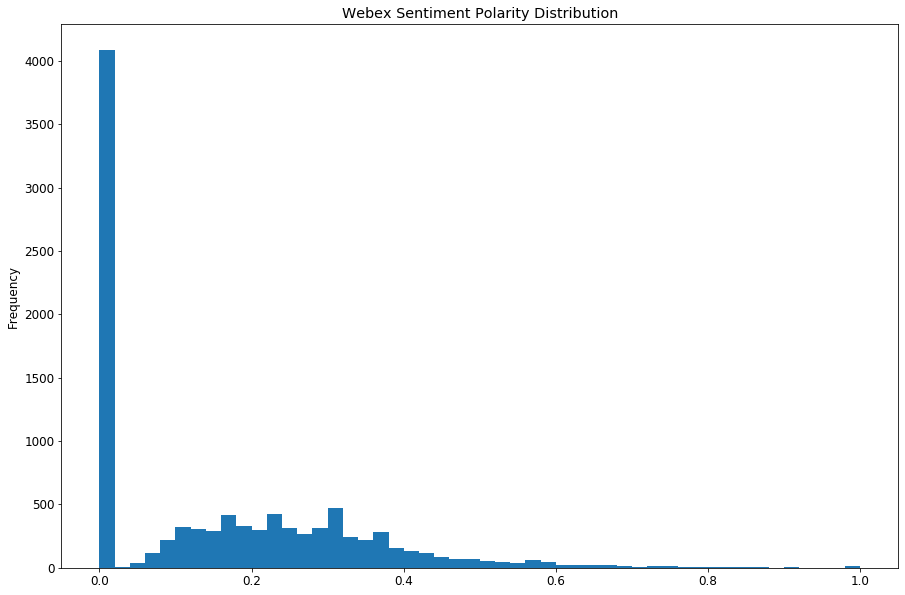

In [75]:
webex_df['pos'].plot(kind='hist', figsize = (15,10), bins=50, title='Webex Sentiment Polarity Distribution')

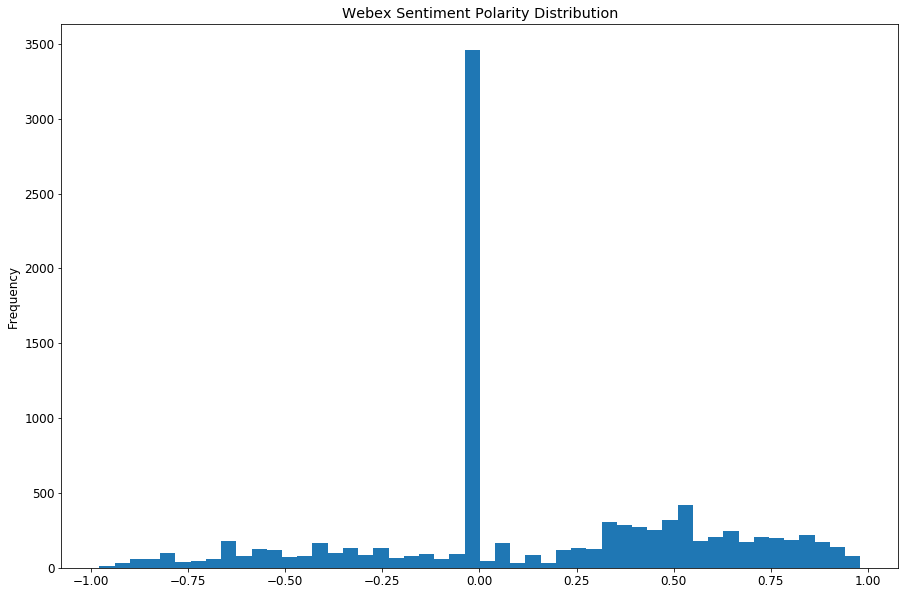

In [65]:
skype_df['compound'].plot(kind='hist', figsize = (15,10), bins=50, title='Webex Sentiment Polarity Distribution')

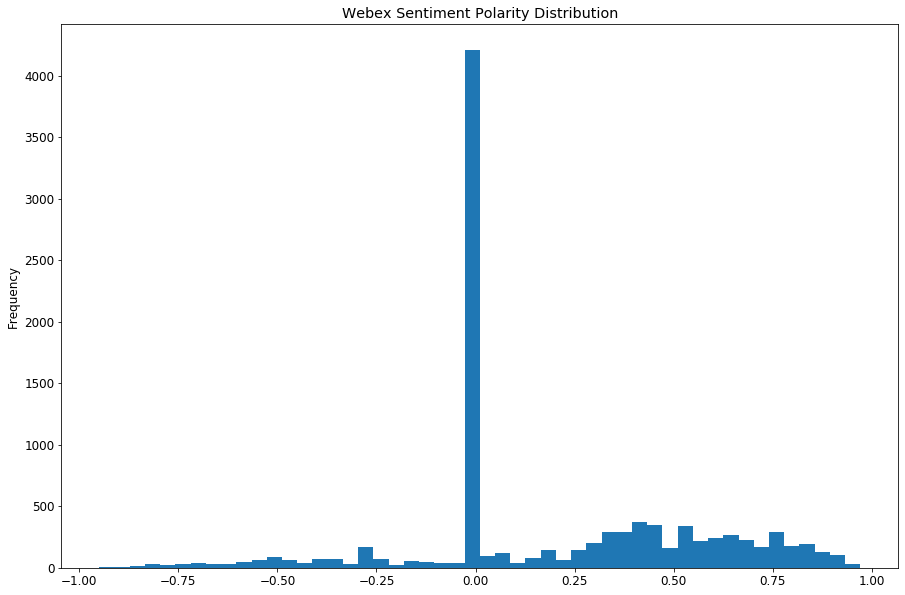

In [64]:
teams_df['compound'].plot(kind='hist', figsize = (15,10), bins=50, title='Webex Sentiment Polarity Distribution')

64     ‘Tis the season, as they say, for jolly good fun and some #holiday tunes. Here is how #Webex has given us all some amazing gifts for #Collaboration! #cisco #ciscowebex http://bit.ly/2SNjnzh pic.twitter.com/E2yIGnIOlg                                                                                              
138    ‘Tis the season, as they say, for jolly good fun and some #holiday tunes. Here is how #Webex has given us all some amazing gifts for #Collaboration! #cisco http://bit.ly/2QE94eb pic.twitter.com/nzUXYgqBGW                                                                                                          
266    Today I was on WebEx with a beautiful young lady from Kenya. She said “You are so beautiful. You look like one of us”.  My genetic make up is infused with so much that most time I feel I have no identity so this made my heart smile. ♥️                                                                           
304    Meetings and Room Devices: The Best Col

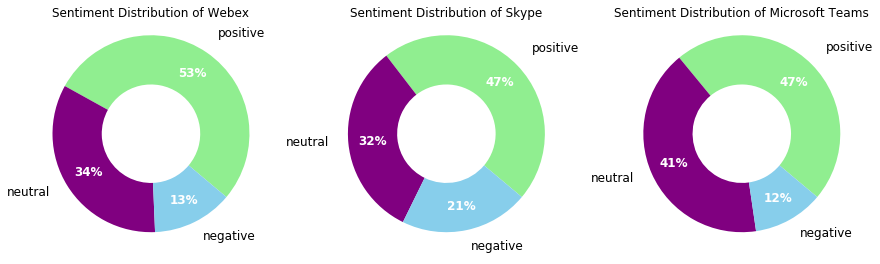

In [12]:
# import necessary modules (if not already imported)
import matplotlib.pyplot as plt

# Set font size
plt.rcParams['font.size']=12

# Define figure
fig, (ax1, ax2, ax3) = plt.subplots( 1, 3 , figsize=(15, 20), subplot_kw=dict(aspect="equal"))

# Get count by sentiment category from tweets_df
webex = tweets_df[tweets_df['product'] == 'webex'].Sentiment.value_counts()
skype = tweets_df[tweets_df['product'] == 'skype'].Sentiment.value_counts()
teams = tweets_df[tweets_df['product'] == 'teams'].Sentiment.value_counts()


# sentiment_counts = tweets_df.Sentiment.value_counts()
labels = ['positive', 'neutral', 'negative']

# Define colors
color_palette_list = ['lightgreen', 'purple', 'skyblue']

# Generate graph components
wedges, texts, autotexts = ax1.pie(webex, wedgeprops=dict(width=0.5), startangle=-40,  
       colors=color_palette_list[0:3], autopct='%1.0f%%', pctdistance=.75, textprops={'color':"w", 'weight':'bold'})

# Plot wedges
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    ax1.annotate(labels[i], xy=(x, y), xytext=(1.2*x, 1.2*y),
                horizontalalignment=horizontalalignment)
# Set title
ax1.set_title("Sentiment Distribution of Webex", y=.95, fontsize = 12)

# Generate graph components
wedges, texts, autotexts = ax2.pie(skype, wedgeprops=dict(width=0.5), startangle=-40,  
       colors=color_palette_list[0:3], autopct='%1.0f%%', pctdistance=.75, textprops={'color':"w", 'weight':'bold'})

# Plot wedges
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    ax2.annotate(labels[i], xy=(x, y), xytext=(1.2*x, 1.2*y),
                horizontalalignment=horizontalalignment)
# Set title
ax2.set_title("Sentiment Distribution of Skype", y=.95, fontsize = 12)

# Generate graph components
wedges, texts, autotexts = ax3.pie(teams, wedgeprops=dict(width=0.5), startangle=-40,  
       colors=color_palette_list[0:3], autopct='%1.0f%%', pctdistance=.75, textprops={'color':"w", 'weight':'bold'})

# Plot wedges
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    ax3.annotate(labels[i], xy=(x, y), xytext=(1.2*x, 1.2*y),
                horizontalalignment=horizontalalignment)
# Set title
ax3.set_title("Sentiment Distribution of Microsoft Teams", y=.95, fontsize = 12)

# Show Donut Chart
plt.show()

In [13]:
#got tired of trying to plot graphs with one dataframe with values for 3 products 
#so just breaking it back up to three seperate product dataframe
#try to all the preprocessing on the entire tweets_df but graphing is easier for seperate DFs
webex_df = tweets_df[tweets_df['product'] == 'webex']
skype_df = tweets_df[tweets_df['product'] == 'skype']
teams_df = tweets_df[tweets_df['product'] == 'teams']

In [14]:
webex_df.Sentiment.unique()

array(['Negative', 'Positive', 'Neutral'], dtype=object)

In [15]:
from collections import Counter
#creating a giant list of all tokens in the column "Tokens" to see the most common tokens

webex_postive_rows = webex_df[webex_df['Sentiment'] == "Positive"]
webex_negative_rows = webex_df[webex_df['Sentiment'] == "Negative"]

webex_bigPostivie_list = []
for index, row in webex_postive_rows.iterrows():
    little_list = webex_postive_rows['Tokens'][index]
    for i in range(0,len(little_list)-1):
        webex_bigPostivie_list.append(little_list[i])
        
webex_bigPostivie_list = [t.lower() for t in webex_bigPostivie_list]
webex_bigPostivie_list_counts = Counter(webex_bigPostivie_list)
webex_Postiive_token25 = webex_bigPostivie_list_counts.most_common(25)
    
webex_bigNegative_list = []
for index, row in webex_negative_rows.iterrows():
    little_list = webex_negative_rows['Tokens'][index]
    for i in range(0,len(little_list)-1):
        webex_bigNegative_list.append(little_list[i])
        
webex_bigNegative_list = [t.lower() for t in webex_bigNegative_list]
webex_bigNegative_list_counts = Counter(webex_bigNegative_list)
webex_Negative_token25 = webex_bigNegative_list_counts.most_common(25)
        


skype_postive_rows = skype_df[skype_df['Sentiment'] == "Positive"]
skype_negative_rows = skype_df[skype_df['Sentiment'] == "Negative"]

skype_bigPostivie_list = []
for index, row in skype_postive_rows.iterrows():
    little_list = skype_postive_rows['Tokens'][index]
    for i in range(0,len(little_list)-1):
        skype_bigPostivie_list.append(little_list[i])
        
skype_bigPostivie_list = [t.lower() for t in skype_bigPostivie_list]
skype_bigPostivie_list_counts = Counter(skype_bigPostivie_list)
skype_Postiive_token25 = skype_bigPostivie_list_counts.most_common(25)
    
skype_bigNegative_list = []
for index, row in skype_negative_rows.iterrows():
    little_list = skype_negative_rows['Tokens'][index]
    for i in range(0,len(little_list)-1):
        skype_bigNegative_list.append(little_list[i])
        
skype_bigNegative_list = [t.lower() for t in skype_bigNegative_list]
skype_bigNegative_list_counts = Counter(skype_bigNegative_list)
skype_Negative_token25 = skype_bigNegative_list_counts.most_common(25)
    
    
teams_postive_rows = teams_df[teams_df['Sentiment'] == "Positive"]
teams_negative_rows = teams_df[teams_df['Sentiment'] == "Negative"]

teams_bigPostivie_list = []
for index, row in teams_postive_rows.iterrows():
    little_list = teams_postive_rows['Tokens'][index]
    for i in range(0,len(little_list)-1):
        teams_bigPostivie_list.append(little_list[i])
        
teams_bigPostivie_list = [t.lower() for t in teams_bigPostivie_list]
teams_bigPostivie_list_counts = Counter(teams_bigPostivie_list)
teams_Postiive_token25 = teams_bigPostivie_list_counts.most_common(25)
    
teams_bigNegative_list = []
for index, row in teams_negative_rows.iterrows():
    little_list = teams_negative_rows['Tokens'][index]
    for i in range(0,len(little_list)-1):
        teams_bigNegative_list.append(little_list[i])
        
teams_bigNegative_list = [t.lower() for t in teams_bigNegative_list]
teams_bigNegative_list_counts = Counter(teams_bigNegative_list)
teams_Negative_token25 = teams_bigNegative_list_counts.most_common(25)
        

    


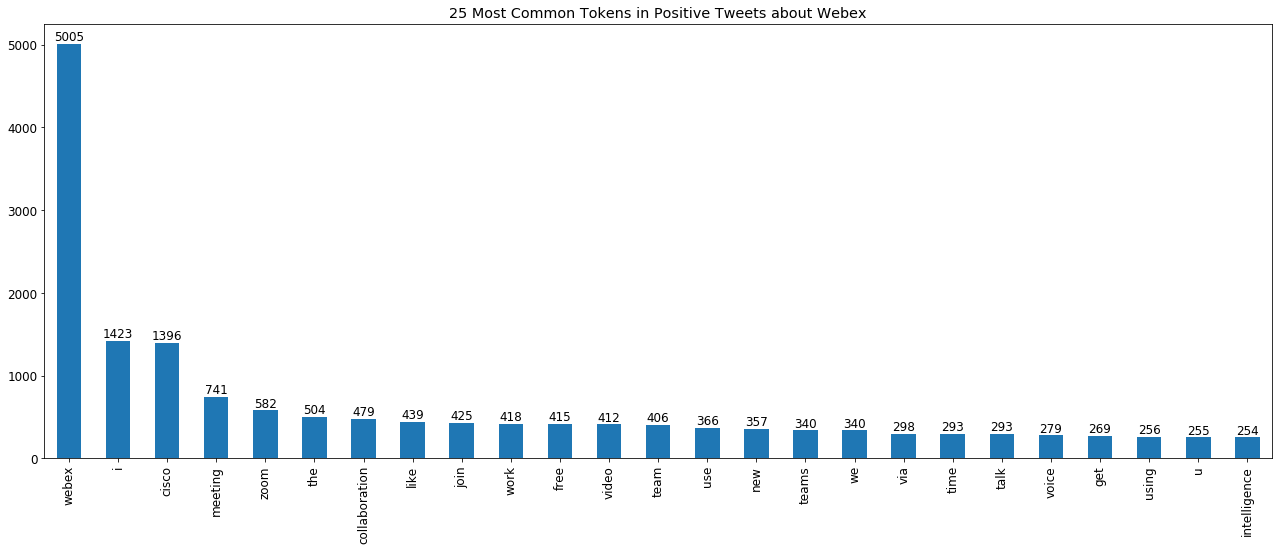

In [16]:
x_labels = [val[0] for val in webex_Postiive_token25]
y_labels = [val[1] for val in webex_Postiive_token25]
plt.figure(figsize=(22, 8))
plt.title("25 Most Common Tokens in Positive Tweets about Webex")
ax = pd.Series(y_labels).plot(kind='bar')
ax.set_xticklabels(x_labels)


rects = ax.patches

for rect, label in zip(rects, y_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

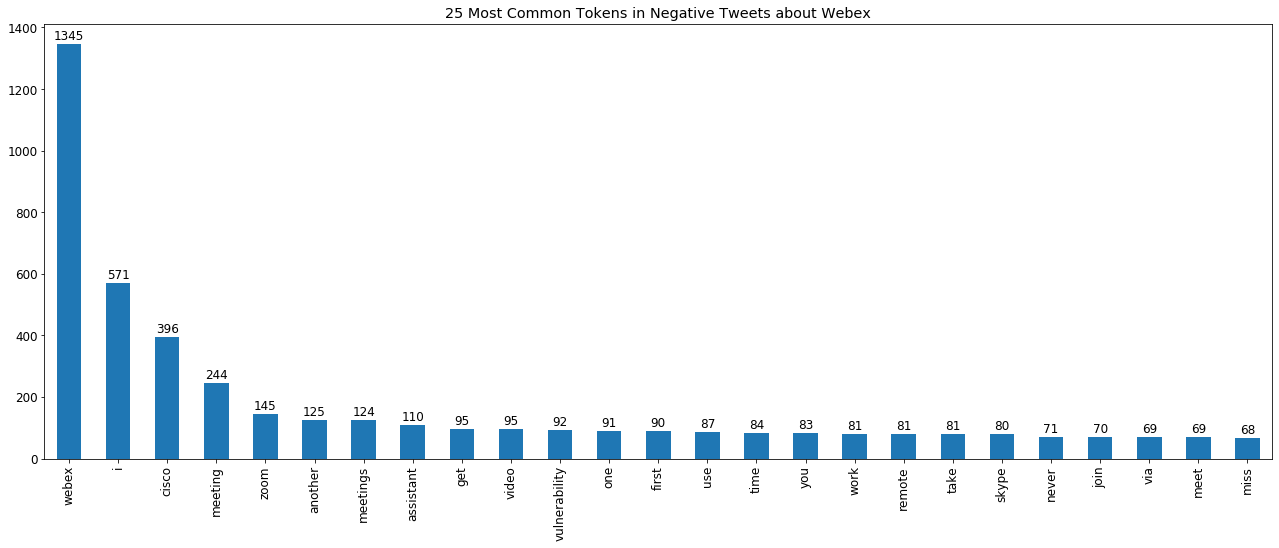

In [17]:
x_labels = [val[0] for val in webex_Negative_token25]
y_labels = [val[1] for val in webex_Negative_token25]
plt.figure(figsize=(22, 8))
plt.title("25 Most Common Tokens in Negative Tweets about Webex")
ax = pd.Series(y_labels).plot(kind='bar')
ax.set_xticklabels(x_labels)

rects = ax.patches

for rect, label in zip(rects, y_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

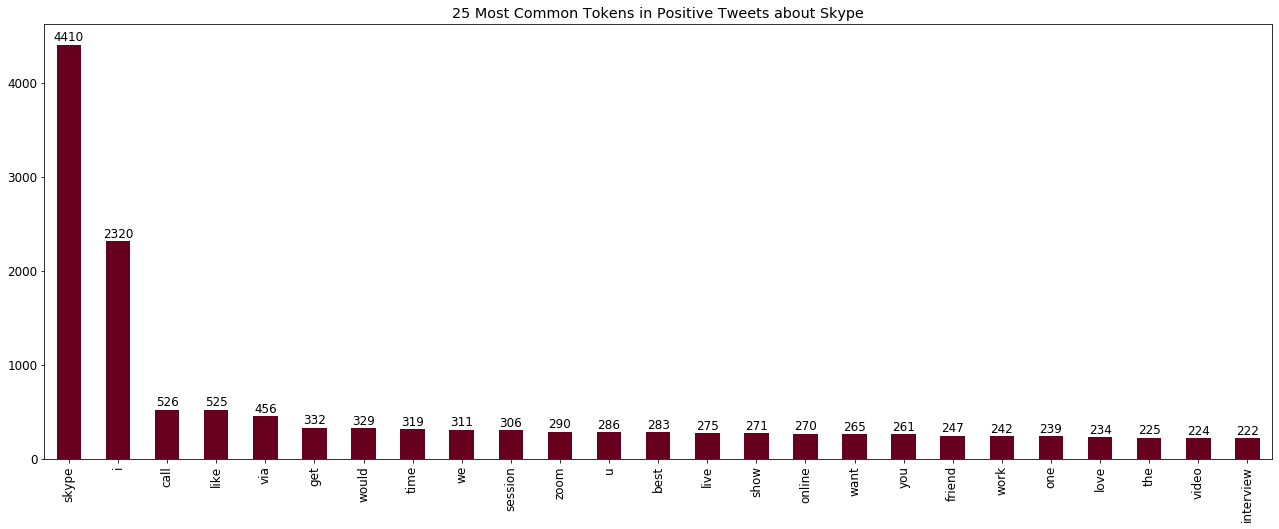

In [18]:
x_labels = [val[0] for val in skype_Postiive_token25]
y_labels = [val[1] for val in skype_Postiive_token25]
plt.figure(figsize=(22, 8))
plt.title("25 Most Common Tokens in Positive Tweets about Skype")
ax = pd.Series(y_labels).plot(kind='bar', colormap = 'RdBu')
ax.set_xticklabels(x_labels)

rects = ax.patches

for rect, label in zip(rects, y_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

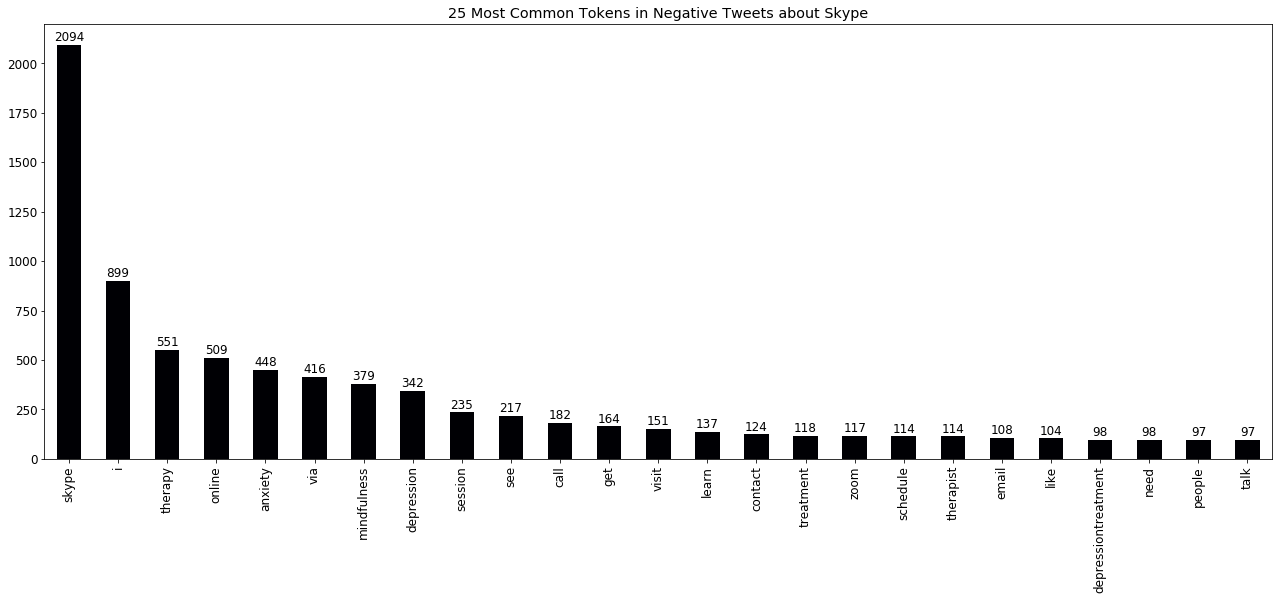

In [19]:
x_labels = [val[0] for val in skype_Negative_token25]
y_labels = [val[1] for val in skype_Negative_token25]
plt.figure(figsize=(22, 8))
plt.title("25 Most Common Tokens in Negative Tweets about Skype")
ax = pd.Series(y_labels).plot(kind='bar', colormap = 'magma')
ax.set_xticklabels(x_labels)

rects = ax.patches

for rect, label in zip(rects, y_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')


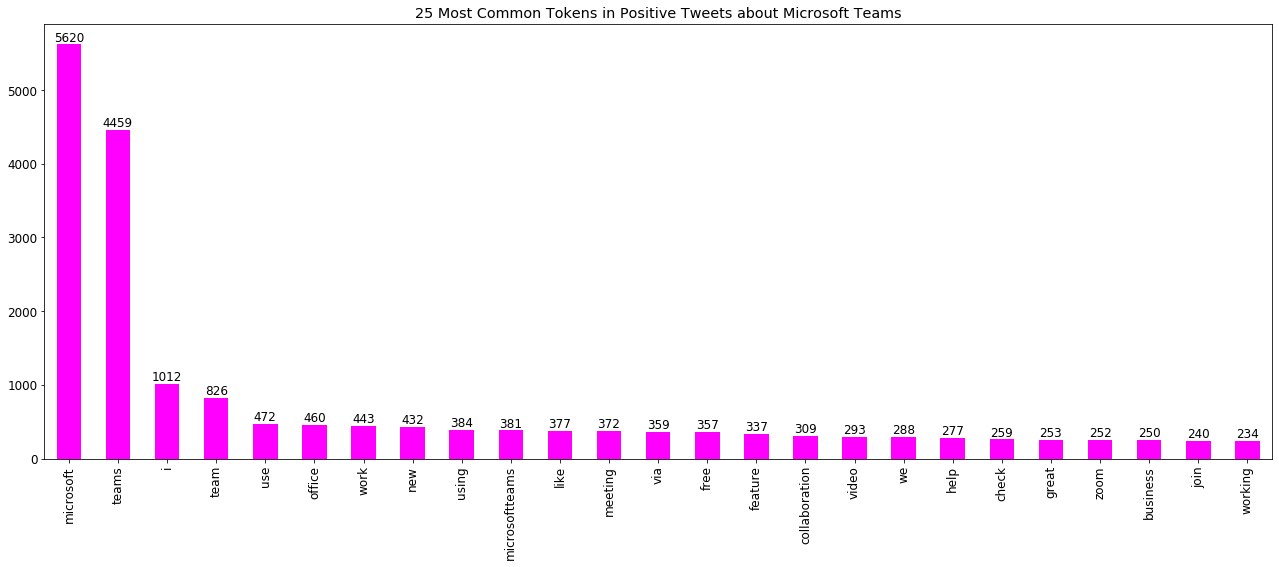

In [20]:
x_labels = [val[0] for val in teams_Postiive_token25]
y_labels = [val[1] for val in teams_Postiive_token25]
plt.figure(figsize=(22, 8))
plt.title("25 Most Common Tokens in Positive Tweets about Microsoft Teams")
ax = pd.Series(y_labels).plot(kind='bar', colormap = 'spring')
ax.set_xticklabels(x_labels)

rects = ax.patches

for rect, label in zip(rects, y_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

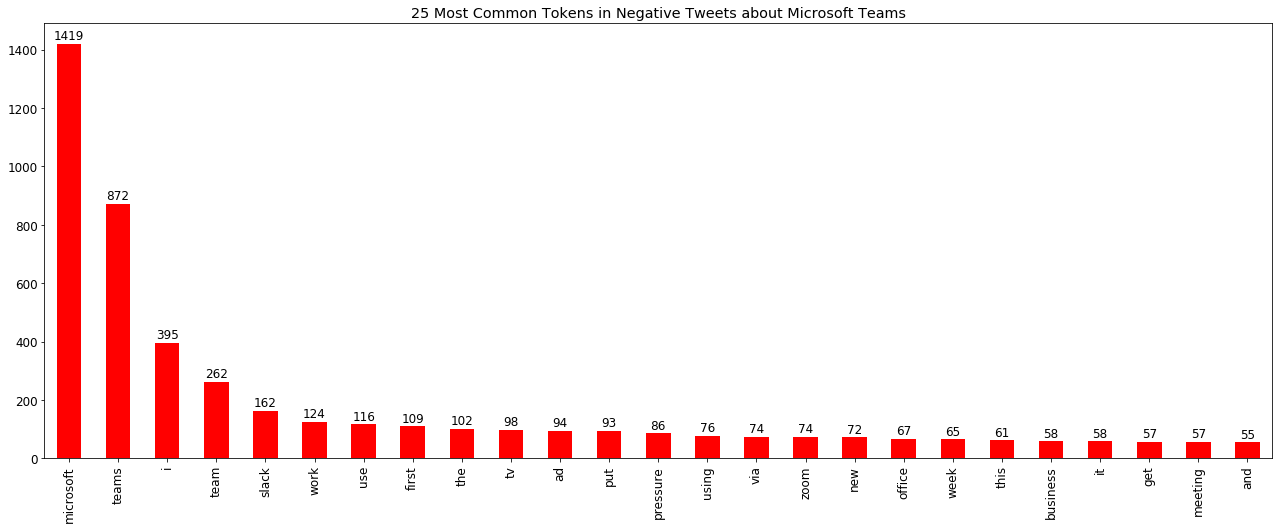

In [21]:
x_labels = [val[0] for val in teams_Negative_token25]
y_labels = [val[1] for val in teams_Negative_token25]
plt.figure(figsize=(22, 8))
plt.title("25 Most Common Tokens in Negative Tweets about Microsoft Teams")
ax = pd.Series(y_labels).plot(kind='bar', colormap = 'prism')
ax.set_xticklabels(x_labels)

rects = ax.patches

for rect, label in zip(rects, y_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

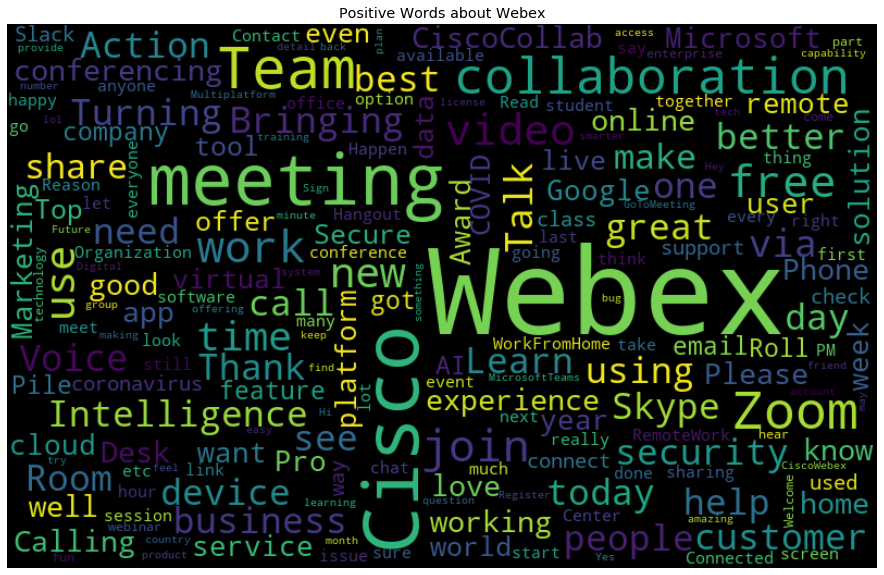

In [22]:
from wordcloud import WordCloud

all_words = ' '.join([text for text in webex_df[webex_df['Sentiment'] == 'Positive']['CleanTweets']])
wordcloud = WordCloud(collocations=False, width=800, height=500, random_state=5, max_font_size=110).generate(all_words)

plt.figure(figsize=(20, 10))
plt.title("Positive Words about Webex")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

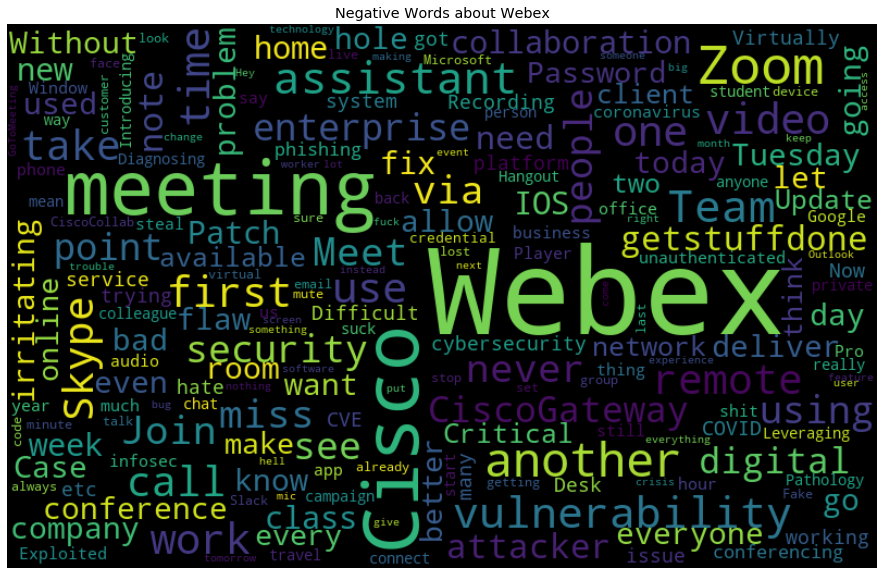

In [23]:
from wordcloud import WordCloud

all_words = ' '.join([text for text in webex_df[webex_df['Sentiment'] == 'Negative']['CleanTweets']])
wordcloud = WordCloud(collocations=False, width=800, height=500, random_state=5, max_font_size=110).generate(all_words)

plt.figure(figsize=(20, 10))
plt.title("Negative Words about Webex")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

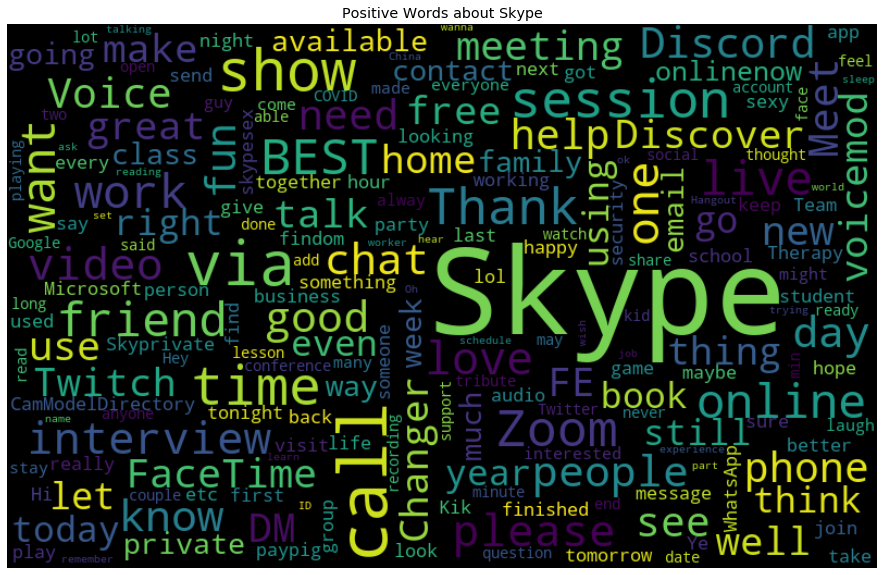

In [24]:
from wordcloud import WordCloud

all_words = ' '.join([text for text in skype_df[skype_df['Sentiment'] == 'Positive']['CleanTweets']])
wordcloud = WordCloud(collocations=False, width=800, height=500, random_state=5, max_font_size=110).generate(all_words)

plt.figure(figsize=(20, 10))
plt.title("Positive Words about Skype")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

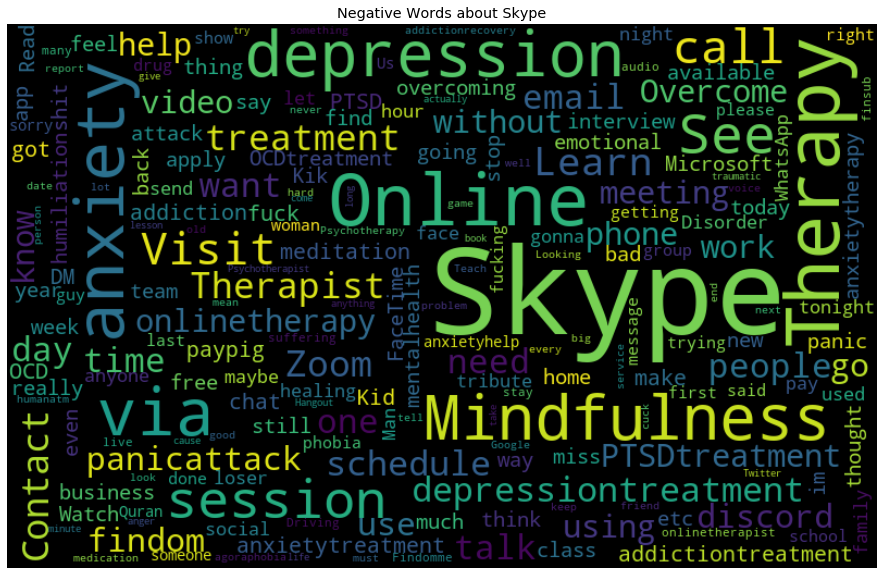

In [25]:
from wordcloud import WordCloud

all_words = ' '.join([text for text in skype_df[skype_df['Sentiment'] == 'Negative']['CleanTweets']])
wordcloud = WordCloud(collocations=False, width=800, height=500, random_state=5, max_font_size=110).generate(all_words)

plt.figure(figsize=(20, 10))
plt.title("Negative Words about Skype")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

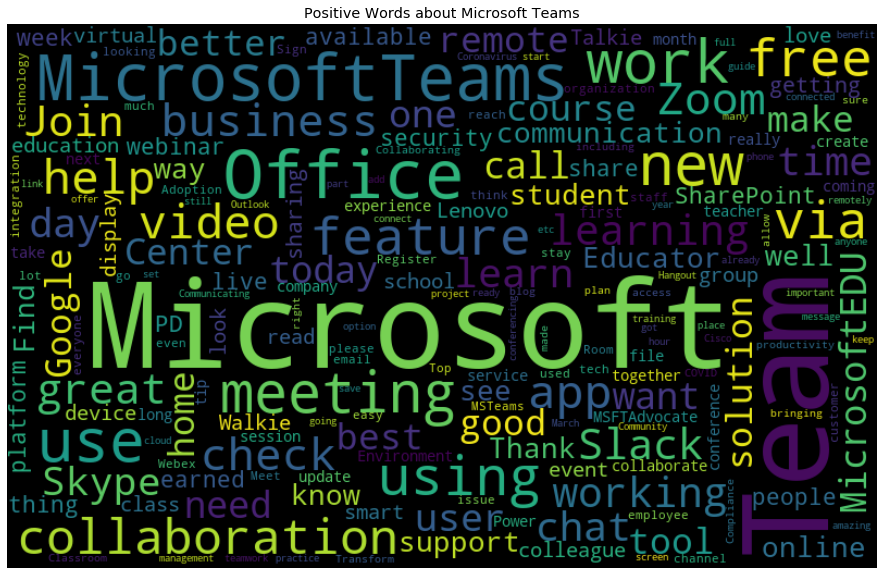

In [26]:
from wordcloud import WordCloud

all_words = ' '.join([text for text in teams_df[teams_df['Sentiment'] == 'Positive']['CleanTweets']])
wordcloud = WordCloud(collocations=False, width=800, height=500, random_state=5, max_font_size=110).generate(all_words)

plt.figure(figsize=(20, 10))
plt.title("Positive Words about Microsoft Teams")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

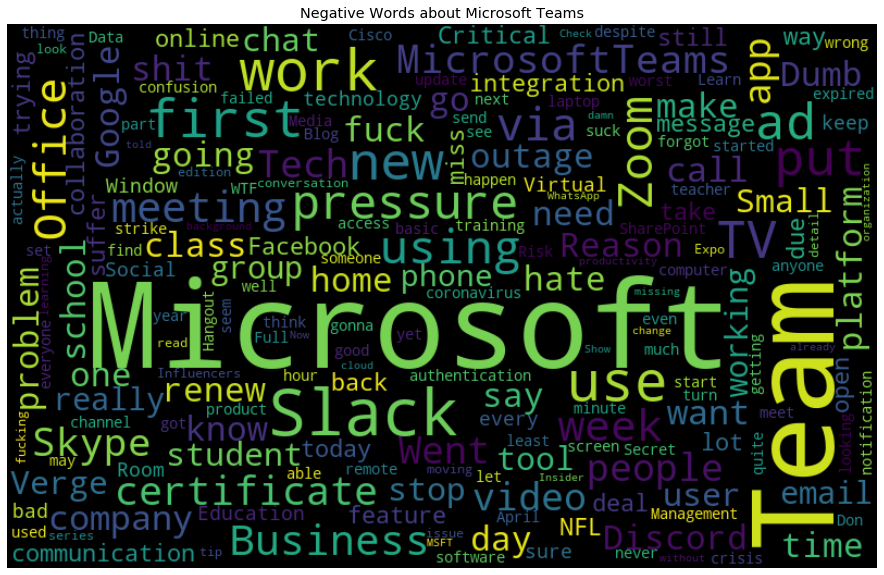

In [27]:
from wordcloud import WordCloud

all_words = ' '.join([text for text in teams_df[teams_df['Sentiment'] == 'Negative']['CleanTweets']])
wordcloud = WordCloud(collocations=False, width=800, height=500, random_state=5, max_font_size=110).generate(all_words)

plt.figure(figsize=(20, 10))
plt.title("Negative Words about Microsoft Teams")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [29]:
#there was one tweet that was messed up and it took me forever to figure it out so hence the variable naming

fucked_dates = tweets_df[tweets_df['timestamp'] == '0']
fucked_dates
# tweets_df.iloc[5850, :]
tweets_df = tweets_df.drop(tweets_df.index[5850])


In [30]:
#took me forever to 
tweets_df['date'] = pd.to_datetime(tweets_df['timestamp'], format='%Y-%m-%d %H:%M:%S')
tweets_df['date'] = tweets_df['date'].dt.date
tweets_df['date']

0        2020-01-03
1        2020-01-03
2        2020-01-03
3        2020-01-03
4        2020-01-03
            ...    
30142    2020-01-29
30143    2020-01-29
30144    2020-01-29
30145    2020-01-29
30146    2020-01-29
Name: date, Length: 30146, dtype: object

In [31]:
#recreating these dataframes so that they contain the new date object,
# because working with dates is the most annoying thing in the entire world

webex_df = tweets_df[tweets_df['product'] == 'webex']
skype_df = tweets_df[tweets_df['product'] == 'skype']
teams_df = tweets_df[tweets_df['product'] == 'teams']

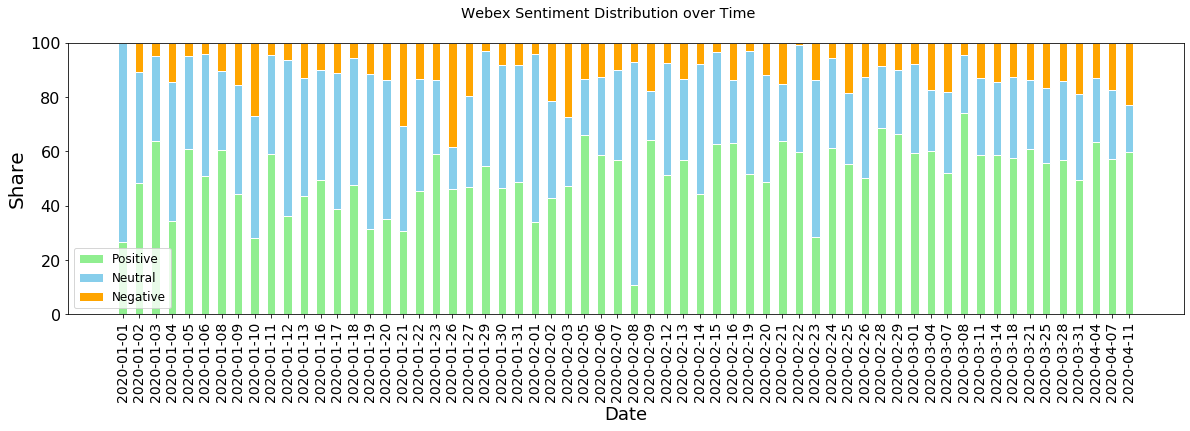

In [33]:
import math
webex_df = webex_df.sort_values(by=['date'])
sentiments = ["Positive", "Neutral", "Negative"]
positiveProps = (webex_df[webex_df.Sentiment == 'Positive'].groupby(['date']).count()[['Sentiment']]/ webex_df.groupby(['date']).count()[['Sentiment']])*100
neutralProps = (webex_df[webex_df.Sentiment == 'Neutral'].groupby(['date']).count()[['Sentiment']]/ webex_df.groupby(['date']).count()[['Sentiment']])*100
negativeProps = (webex_df[webex_df.Sentiment == 'Negative'].groupby(['date']).count()[['Sentiment']]/ webex_df.groupby(['date']).count()[['Sentiment']])*100
 
positiveProps = positiveProps['Sentiment'].tolist()
neutralProps = neutralProps['Sentiment'].tolist()
negativeProps = negativeProps['Sentiment'].tolist()
plt.figure(figsize=[20, 5])
barWidth = 0.5
labels = webex_df.date.unique()
r = np.arange(len(labels))
positiveProps = [0 if math.isnan(x) else x for x in positiveProps]
neutralProps = [0 if math.isnan(x) else x for x in neutralProps]
negativeProps = [0 if math.isnan(x) else x for x in negativeProps]

plt.bar(r,positiveProps, color='lightgreen', edgecolor='white', width=barWidth)
plt.bar(r, neutralProps, bottom=positiveProps, color='skyblue', edgecolor='white', width=barWidth)
plt.bar(r, negativeProps, bottom=[i+j for i,j in zip(positiveProps, neutralProps)], color='orange', edgecolor='white', width=barWidth)
 
plt.xticks(r, labels, rotation = 90, fontsize=14)
plt.yticks(fontsize=16)
plt.suptitle('Webex Sentiment Distribution over Time')
plt.xlabel("Date", fontsize=18)
plt.ylabel("Share", fontsize=20)
plt.legend(sentiments)
plt.show()

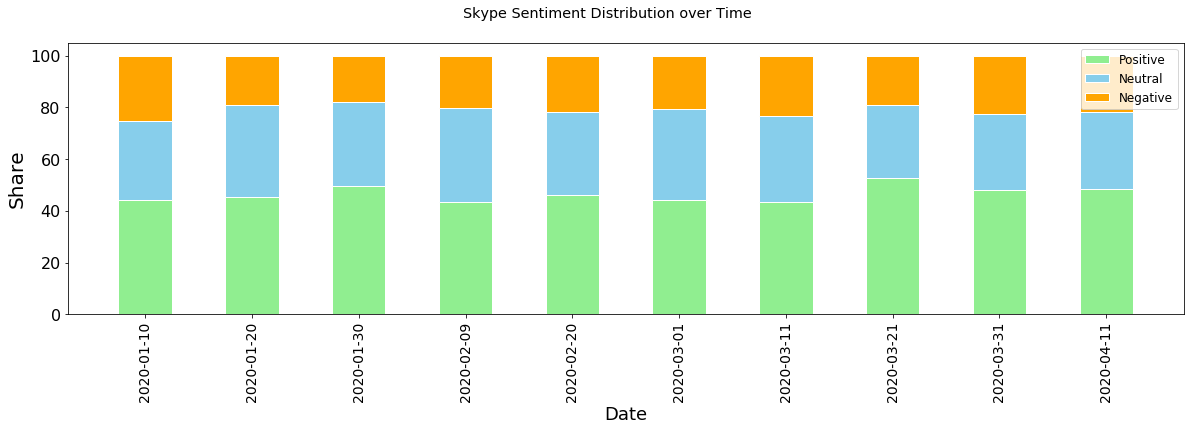

In [34]:
skype_df = skype_df.sort_values(by=['date'])
sentiments = ["Positive", "Neutral", "Negative"]
positiveProps = (skype_df[skype_df.Sentiment == 'Positive'].groupby(['date']).count()[['Sentiment']]/ skype_df.groupby(['date']).count()[['Sentiment']])*100
neutralProps = (skype_df[skype_df.Sentiment == 'Neutral'].groupby(['date']).count()[['Sentiment']]/ skype_df.groupby(['date']).count()[['Sentiment']])*100
negativeProps = (skype_df[skype_df.Sentiment == 'Negative'].groupby(['date']).count()[['Sentiment']]/ skype_df.groupby(['date']).count()[['Sentiment']])*100
 
positiveProps = positiveProps['Sentiment'].tolist()
neutralProps = neutralProps['Sentiment'].tolist()
negativeProps = negativeProps['Sentiment'].tolist()
plt.figure(figsize=[20, 5])
barWidth = 0.5
labels = skype_df.date.unique()
r = np.arange(len(labels))
positiveProps = [0 if math.isnan(x) else x for x in positiveProps]
neutralProps = [0 if math.isnan(x) else x for x in neutralProps]
negativeProps = [0 if math.isnan(x) else x for x in negativeProps]

plt.bar(r,positiveProps, color='lightgreen', edgecolor='white', width=barWidth)
plt.bar(r, neutralProps, bottom=positiveProps, color='skyblue', edgecolor='white', width=barWidth)
plt.bar(r, negativeProps, bottom=[i+j for i,j in zip(positiveProps, neutralProps)], color='orange', edgecolor='white', width=barWidth)
 
plt.xticks(r, labels, rotation = 90, fontsize=14)
plt.yticks(fontsize=16)
plt.suptitle('Skype Sentiment Distribution over Time')
plt.xlabel("Date", fontsize=18)
plt.ylabel("Share", fontsize=20)
plt.legend(sentiments)
plt.show()

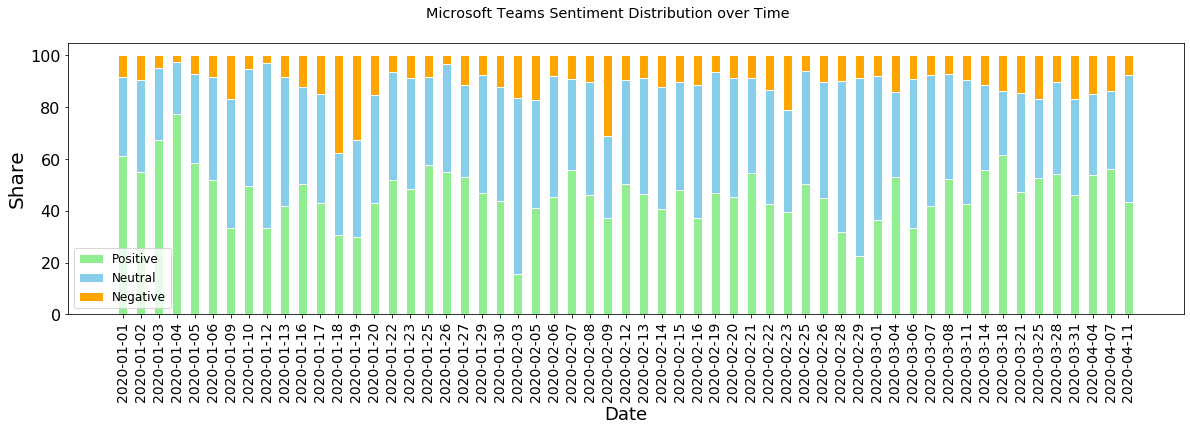

In [35]:
teams_df = teams_df.sort_values(by=['date'])
sentiments = ["Positive", "Neutral", "Negative"]
positiveProps = (teams_df[teams_df.Sentiment == 'Positive'].groupby(['date']).count()[['Sentiment']]/ teams_df.groupby(['date']).count()[['Sentiment']])*100
neutralProps = (teams_df[teams_df.Sentiment == 'Neutral'].groupby(['date']).count()[['Sentiment']]/ teams_df.groupby(['date']).count()[['Sentiment']])*100
negativeProps = (teams_df[teams_df.Sentiment == 'Negative'].groupby(['date']).count()[['Sentiment']]/ teams_df.groupby(['date']).count()[['Sentiment']])*100
 
positiveProps = positiveProps['Sentiment'].tolist()
neutralProps = neutralProps['Sentiment'].tolist()
negativeProps = negativeProps['Sentiment'].tolist()
plt.figure(figsize=[20, 5])
barWidth = 0.5
labels = teams_df.date.unique()
r = np.arange(len(labels))

positiveProps = [0 if math.isnan(x) else x for x in positiveProps]
neutralProps = [0 if math.isnan(x) else x for x in neutralProps]
negativeProps = [0 if math.isnan(x) else x for x in negativeProps]

plt.bar(r,positiveProps, color='lightgreen', edgecolor='white', width=barWidth)
plt.bar(r, neutralProps, bottom=positiveProps, color='skyblue', edgecolor='white', width=barWidth)
plt.bar(r, negativeProps, bottom=[i+j for i,j in zip(positiveProps, neutralProps)], color='orange', edgecolor='white', width=barWidth)
 
plt.xticks(r, labels, rotation = 90, fontsize=14)
plt.yticks(fontsize=16)
plt.suptitle('Microsoft Teams Sentiment Distribution over Time')
plt.xlabel("Date", fontsize=18)
plt.ylabel("Share", fontsize=20)
plt.legend(sentiments)
plt.show()

In [36]:
tweets_df['month'] = pd.DatetimeIndex(tweets_df['date']).month

In [37]:
jan_df = tweets_df[tweets_df['month'] == 1]
feb_df = tweets_df[tweets_df['month'] == 2]
march_df = tweets_df[tweets_df['month'] == 3]
april_df = tweets_df[tweets_df['month'] == 4]

In [42]:
#recreating these dataframes so that they contain the new date object,
# because working with dates is the most annoying thing in the entire world

webex_df = tweets_df[tweets_df['product'] == 'webex']
skype_df = tweets_df[tweets_df['product'] == 'skype']
teams_df = tweets_df[tweets_df['product'] == 'teams']

In [48]:
tweets_df.to_csv('tweets_df.csv')
webex_df.to_csv('webex_df.csv')
skype_df.to_csv('skype_df.csv')
teams_df.to_csv('teams_df.csv')

In [77]:
tweets_df.head(1)

,Unnamed: 0,likes,parent_tweet_id,product,replies,retweets,screen_name,text,timestamp,tweet_id,...,stripped,pos,neu,neg,compound,overall_sentiment,C_Score,Sentiment,date,month
0,0,0.0,1.213231e+18,webex,1.0,0.0,monkeyedwards,Webex account limitation on attendees ?,2020-01-03 22:53:19,1.213232e+18,...,Webex account limitation on attendees ?,0.0,0.577,0.423,-0.296,Negative,-0.296,Negative,2020-01-03,1


In [87]:
tweets_df['security'] = tweets_df['stripped'].str.contains('security') 
bombing = tweets_df[tweets_df['security'] == True]

In [88]:
bombing.text

148      New decade = New Reporting. Sign up for your free 15-minute WebEx today. #sage50 #cascade50 #sage50cloud #reporting #dashboards #securityhttps://lnkd.in/dNCHzfM                                                                                                                                                      
181      We click on phishing emails so you don’t have to! This week we look at a very well crafted phishing campaign that attempts to steal your WebEx credentials.\nhttp://ow.ly/URDT50xLa2x \n#PhightPhish #cyberthreats #phish #emailsecurity #onlinesafety #cyberattacks #cybersecurity                                   
222      See how BBVA seamless merged #security and customer-like experiences by choosing #Webex Teams to solve their unique collaboration challenges. #cisco http://bit.ly/2TJShcW pic.twitter.com/zWJbq5qnAP                                                                                                                 
239      See how BBVA seamless merged #s

In [100]:
skype_df['companyTweet'] = skype_df['screen_name'].str.contains('depression')
company_tweets = teams_df[teams_df['screen_name'] == 'Microsoft']
len(company_tweets)

0

In [99]:
company_tweets

,Unnamed: 0,likes,parent_tweet_id,product,replies,retweets,screen_name,text,timestamp,tweet_id,...,stripped,pos,neu,neg,compound,overall_sentiment,C_Score,Sentiment,date,month
14744,4751,4.0,1.230491e+18,skype,0.0,1.0,Skype,Cookies and a Skype session? It doesn't get much better than that! 😎,2020-02-20 17:13:03,1.230541e+18,...,Cookies and a Skype session? It doesn't get much better than that! 😎,0.326,0.674,0.000,0.4404,Positive,0.2230,Positive,2020-02-20,2
14755,4762,1.0,1.230516e+18,skype,1.0,1.0,Skype,"That sounds like it will be a fun, engaging session! Let us know what questions they come up with, Colleen!",2020-02-20 17:08:08,1.230540e+18,...,"That sounds like it will be a fun, engaging session! Let us know what questions they come up with, Colleen!",0.477,0.523,0.000,0.8020,Positive,0.8309,Positive,2020-02-20,2
15410,5417,0.0,1.223277e+18,skype,0.0,0.0,Skype,"Hi there! Your tweet caught our attention, and we'll do our best to help. We've sent you a message via DM, so please check your inbox. Thank you!",2020-03-21 23:02:50,1.241501e+18,...,"Hi there! Your tweet caught our attention, and we'll do our best to help. We've sent you a message via DM, so please check your inbox. Thank you!",0.515,0.485,0.000,0.8934,Positive,0.9182,Positive,2020-03-21,3
16337,6344,6.0,1.215721e+18,skype,0.0,0.0,Skype,We love a good Skype session with friends building up a wild Minecraft world!,2020-01-10 21:50:32,1.215753e+18,...,We love a good Skype session with friends building up a wild Minecraft world!,0.595,0.405,0.000,0.8834,Positive,0.8883,Positive,2020-01-10,1
16566,6573,2.0,1.215721e+18,skype,1.0,0.0,Skype,Nothing like taking a Skype call for work from the comfort of your own home!,2020-01-10 20:14:00,1.215729e+18,...,Nothing like taking a Skype call for work from the comfort of your own home!,0.236,0.566,0.199,0.1002,Positive,0.1734,Positive,2020-01-10,1
16665,6672,88.0,NaN,skype,47.0,9.0,Skype,What's the best news you've shared over Skype?,2020-01-10 19:45:00,1.215721e+18,...,What's the best news you've shared over Skype?,0.767,0.233,0.000,0.7650,Positive,0.7650,Positive,2020-01-10,1
16760,6767,0.0,1.213659e+18,skype,0.0,0.0,Skype,We hope that we covered everything here in Social Media before we close this case. Have a great day! 😊 3/3,2020-01-10 19:08:04,1.215712e+18,...,We hope that we covered everything here in Social Media before we close this case. Have a great day! 😊 3/3,0.438,0.562,0.000,0.7906,Positive,0.9230,Positive,2020-01-10,1
16761,6768,0.0,1.213659e+18,skype,0.0,0.0,Skype,"In case you're unable to cancel it via that link, you may also iget in touch with our Skype chat support for further assistance: https://msft.it/6017TkBLb . 2/3",2020-01-10 19:07:52,1.215712e+18,...,"In case you're unable to cancel it via that link, you may also iget in touch with our Skype chat support for further assistance: . 2/3",0.162,0.719,0.120,0.1779,Positive,0.1779,Positive,2020-01-10,1
16762,6769,0.0,1.213659e+18,skype,0.0,0.0,Skype,"Hello, there. We hope that you're doing good. You have contacted us regarding canceling your Skype subscription. We have provided you a link and steps on how and where to cancel it. 1/3",2020-01-10 19:07:42,1.215712e+18,...,"Hello, there. We hope that you're doing good. You have contacted us regarding canceling your Skype subscription. We have provided you a link and steps on how and where to cancel it. 1/3",0.279,0.625,0.096,0.5859,Positive,0.5859,Positive,2020-01-10,1
16781,6788,0.0,1.214516e+18,skype,0.0,0.0,Skype,We have also advised you to get in touch with our Skype chat support in case you're only experiencing this n your Skype account. We hope that we covered everything here in Social Media before we close this case. Have a nice day! 😊 2/2,2020-01-10 18:57:27,1.215709e+18,...,We have also advised you to get in touch with our Skype chat support in case you're only experiencing this n your Skype account. We hope that we covered everything here in Social Media before we close this case. Have a nice day! 😊 

In [ ]:
company_tweets = teams_df[teams_df['screen_name'] == 'Microsoft']